# Calculate bias between RAMP and S1
Bias of NeRD detected damage between different sensors on same fracture features. Due to the fact that RAMP (1997;2000) and Sentinel 1 (2015-onward) do not overlap in time and "the same fracture feature" is not possible, we have chosen a grounded ice area with terrain shadows (assumed to be somewhat stable over these years) that can be used as proxy for "similar features" between sensor images.

In [1]:
import os
# import rioxarray as rioxr
import xarray as xr
import json
import numpy as np
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
import geopandas as gpd

import seaborn as sns
import pandas as pd
homedir = '/Users/.../'

In [2]:
def plot_crevSig(crevSig_da,ax):
    # fig,axs=plt.subplots(1,2,figsize=(15,8))
    crevSig_da.plot.imshow(ax=ax,vmin=0,vmax=0.2,cmap='magma',add_colorbar=False)
    ax.set_title('crevSig')


In [3]:
threshold_file = os.path.join(homedir,'files/dmg_threshold_dictionary_SAR.json')
with open(threshold_file, 'r') as fp:
    threshold_dict = json.load(fp)

threshold_dict

{'pct0.99': {'RADARSAT': {'img_res': {'100': {'10px': 0.02}},
   'long_name': 'RAMP Radarsat'},
  'S1': {'img_res': {'40': {'10px': 0.063, '25px': 0.051},
    '100': {'10px': 0.046}},
   'long_name': 'Sentinel 1 (EW)'}},
 'pct0.95': {'RADARSAT': {'img_res': {'100': {'10px': 0.016}},
   'long_name': 'RAMP Radarsat'},
  'S1': {'img_res': {'40': {'10px': 0.053, '25px': 0.041},
    '100': {'10px': 0.038}},
   'long_name': 'Sentinel 1 (EW)'}},
 'mean': {'RADARSAT': {'img_res': {'100': {'10px': 0.009}},
   'long_name': 'RAMP Radarsat'},
  'S1': {'img_res': {'40': {'10px': 0.037, '25px': 0.03},
    '100': {'10px': 0.027}},
   'long_name': 'Sentinel 1 (EW)'}}}

In [4]:

def calc_avg_signalValue(path2files,fileList, img_res, n_pix, pct=0.75, 
                            plotC=False, var='crevSig', threshold=None, printValues=True,applyMask=True):    
    all_windows = np.array([])
    area_mean = [];
    area_median = [];
    area_pct = [];
    area_pix = [];
    area_max=[];
    count=0
    
    if plotC:
        fig,axs=plt.subplots(1,len(fileList),figsize=(15,5))
    for fname in fileList: #imList:
        da_out = xr.open_dataarray(os.path.join(path2files,fname))
        # da_out = xr.open_dataarray(fname)
        crevSig = da_out.isel(out=1)
        if var == 'crevSig':
            data= crevSig
        if var == 'dmg':
            if threshold is None:
                raise ValueError('When calculating avg ''dmg'', also provide threshold')
            # convert crevSig to dmg
            dmg = crevSig - threshold
            dmg = dmg.where(dmg>0,0) # xr.where(cond,other) replaces everywhere where condition is FALSEe with 'other' (so in this case where dmg<0)
            # dmg = dmg.where(dmg>0,np.nan)
            data = dmg
        
        if applyMask:
            # mask rocks etc
            data = data.rio.clip(iceStream_mask.geometry, iceStream_mask.crs, drop=False, invert=True)

        ## assemble all pixels into one array
        all_windows = np.concatenate((all_windows,data.dropna(dim='x').dropna(dim='y').values.flatten()))
        
        # calculate avg values per area, but only if there are non-nan pixels
        if ~np.isnan(data.values).all():
            area_mean.append(data.mean(skipna=True).values)
            area_median.append(data.median(skipna=True).values)
            area_pct.append( data.quantile(pct, skipna=True).values)
            area_max.append( data.max(skipna=True).values)
            area_pix.append( data.count().values  )
            
            # plot
            if plotC:
                plot_crevSig(data,axs[count])
            count+=1
    
    # if len(area_mean)>0:
    arr_mean = np.array(area_mean)
    arr_median = np.array(area_median)
    arr_pct = np.array(area_pct)
    arr_max = np.array(area_max)
    arr_pix = np.array(area_pix)
    w_mean = np.sum(arr_pix*arr_mean)/np.sum(arr_pix)
    w_pct = np.sum(arr_pix*arr_pct)/np.sum(arr_pix)
    w_median = np.sum(arr_pix*arr_median)/np.sum(arr_pix)
    w_max  = np.sum(arr_pix*arr_max)/np.sum(arr_pix)

    if printValues:
        print('SUMMARY: {}, imRes={}, Npix={} ----'.format(var, img_res, n_pix))
        print('      | All pixel | Weighted |  Avg area |')
        print('Mean      {:.3f}      {:.4f}     {:.3f}   '.format( all_windows.mean(),w_mean, np.mean(arr_mean) ) )
        print('Median    {:.3f}      {:.4f}     {:.3f}   '.format( np.median( all_windows),w_mean, np.mean(arr_median) ))
        print('Pct{:.2f}   {:.3f}      {:.4f}     {:.3f}   '.format( pct, np.percentile(all_windows, pct*100), w_pct, np.mean(arr_pct)  ))
        print('Max       {:.3f}      {:.4f}     {:.3f}   '.format( all_windows.max(), w_max, np.mean(arr_max)  ))
        print('-------')
    
    # return all_windows.mean(), np.median(all_windows), all_windows.std(), np.percentile(all_windows, pct*100)
    return all_windows, data



## Calculate average/median signal values for grounded ice

In [5]:
''' --- RAMP --- '''
imPath = os.path.join(homedir,'Data/RAMP/RAMP_iceStreams/')
outPath = os.path.join(imPath,'damage_detection')
varkey='RMP-100:10'; img_res=100; n_pix=10
# tau_ramp = threshold_dict['pct0.99']['RADARSAT']['img_res']['100']['10px']
tau_ramp = threshold_dict['pct0.95']['RADARSAT']['img_res']['100']['10px']
print('RAMP tau: ', tau_ramp)

# get imgs
imList= sorted([file for file in os.listdir(outPath) if file.endswith('.nc') and file.startswith('groundedIce')])
imList = [file for file in imList if str(img_res)+'m' in file] 
imList = [file for file in imList if str(n_pix)+'px'  in file] 

R_all_windows_grounded , R_data = calc_avg_signalValue(outPath, imList, 
                                                            img_res=100, n_pix=10,pct=0.95,
                                                            var='dmg',threshold=tau_ramp, printValues=False)

R_allpx_mean_dmg,  R_allpx_median_dmg ,R_allpx_std_dmg , R_allpx_095  = R_all_windows_grounded.mean(), np.median(R_all_windows_grounded), R_all_windows_grounded.std(), np.percentile(R_all_windows_grounded, 95)

# make dataframe with values. append data
df_values_grounded = pd.DataFrame(columns=['sensor','mean','std','pct095'])
df_values_grounded.loc[len(df_values_grounded.index)] = [varkey, R_allpx_mean_dmg, R_allpx_std_dmg, R_allpx_095]


''' --- Sentinel 1 --- '''
imPath = os.path.join(homedir,'Data/S1_SAR/relorbs/iceStreams/')
outPath = os.path.join(imPath,'damage_detection')

# Define noise threshold for img:window resolutions      
threshold_dict['pct0.95']['RADARSAT']['img_res']['100']['10px']
S1_processed = [( 'S1-100:10',threshold_dict['pct0.95']['S1']['img_res']['100']['10px'] ),  
                ( 'S1-40:25', threshold_dict['pct0.95']['S1']['img_res']['40']['25px'] ) ,  
                ( 'S1-40:10', threshold_dict['pct0.95']['S1']['img_res']['40']['10px']),   
                ]

print('S1 tau: ',S1_processed)


S1_vars = []
S1_vals_crevSig = []
S1_vals_dmg = []
dict_S1_R_diff = {}
dict_S1={}
print('                 DMG: mean      std     pct095')
print('All px {:10s} : {:.3f}   | {:.3f}  | {:.3f}'.format( varkey, R_allpx_mean_dmg  ,R_allpx_std_dmg, R_allpx_095 ))
S1_data = []
S1_all_windows = []
ALL_windows_grounded = [R_all_windows_grounded]
for varkey,tresh in S1_processed:
    img_res = varkey.split('-')[-1].split(':')[0]
    n_pix = varkey.split('-')[-1].split(':')[1]

    # get imgs
    imList= sorted([file for file in os.listdir(outPath) if file.endswith('.nc') and file.startswith('groundedIce')])
    imList = [file for file in imList if str(img_res)+'m' in file] 
    imList = [file for file in imList if str(n_pix)+'px'  in file] 
    if not imList:
        raise ValueError('Did not find files for {}:{} in {}'.format(img_res,n_pix, outPath)) # path2files))
    
    # calc values
    all_windows, data = calc_avg_signalValue(outPath, imList, 
                                            img_res=img_res, n_pix=n_pix, pct=0.95,var='dmg',threshold=tresh, printValues=False)
    allpx_mean_dmg  , allpx_median_dmg , allpx_std_dmg, allpx_dmg_095  = all_windows.mean(), np.median(all_windows), all_windows.std(), np.percentile(all_windows, 95)

    print('All px {:10s} : {:.3f}   | {:.3f}  | {:.3f}'.format( varkey, allpx_mean_dmg  , allpx_std_dmg, allpx_dmg_095 ))
    S1_vars.append(varkey)
    S1_vals_dmg.append(allpx_mean_dmg)


    # append to dtaframe
    df_values_grounded.loc[len(df_values_grounded.index)] = [varkey, allpx_mean_dmg, allpx_std_dmg, allpx_dmg_095]

    dict_S1[varkey.split('-')[-1]] = { 'std': allpx_std_dmg,
                                       'dmg_mean': allpx_mean_dmg ,
                                       'dmg_median': allpx_median_dmg }                                               
    dict_S1_R_diff[varkey.split('-')[-1]] = { 'diff_S1-R_mean':   allpx_mean_dmg -  R_allpx_mean_dmg ,
                                              'diff_S1-R_median': allpx_median_dmg-R_allpx_median_dmg }
    S1_data.append(data)
    S1_all_windows.append(all_windows)
    ALL_windows_grounded.append(all_windows)

df_values_grounded

RAMP tau:  0.016
S1 tau:  [('S1-100:10', 0.038), ('S1-40:25', 0.041), ('S1-40:10', 0.053)]
                 DMG: mean      std     pct095
All px RMP-100:10 : 0.008   | 0.015  | 0.039
All px S1-100:10  : 0.010   | 0.023  | 0.061
All px S1-40:25   : 0.009   | 0.022  | 0.055
All px S1-40:10   : 0.002   | 0.010  | 0.016


,sensor,mean,std,pct095
0,RMP-100:10,0.007808,0.015135,0.039459
1,S1-100:10,0.009999,0.023375,0.061082
2,S1-40:25,0.008732,0.021666,0.054730
3,S1-40:10,0.002443,0.010426,0.015698


NOTE: So average differrence is very small. 
 e.g. S1-Ramp 100:10, meandiff= 0.002, way smaller than both their STDs 
 BUT the differences for the higher dmg values is noteworthy: 
Threre S1-R 100:10 pct095diff = 0.022 
... how to accouont for that? Find a scaling factor? 


Text(0.5, 0.98, 'groundedIce')

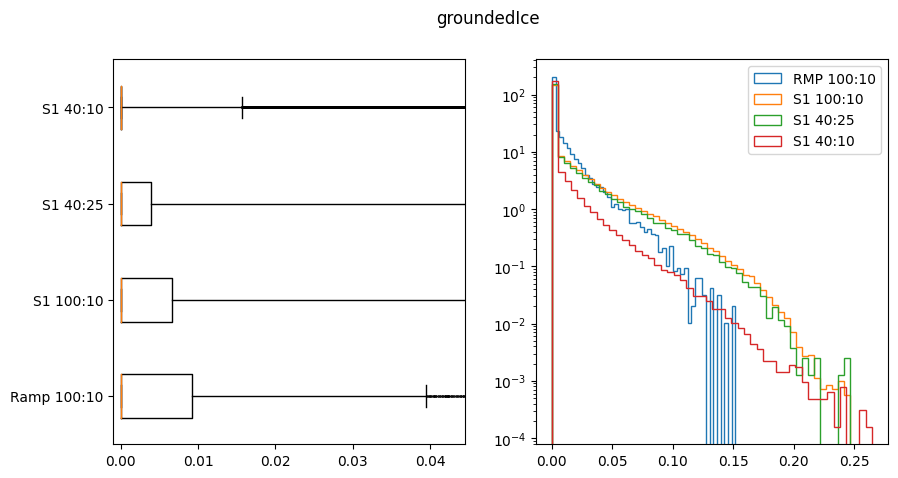

In [6]:
ALL_windows = ALL_windows_grounded

fig,axs=plt.subplots(1,2,figsize=(10,5))
# ax.boxplot(S1_all_windows);

ax=axs[0]

ax.boxplot(ALL_windows,
                flierprops={'markersize':0.1}, #linewidth=1,
                vert=False,
                whis=[5, 95],
                );
# ax = sns.violinplot(ALL_windows,fliersize=1,orient='h',linewidth=0.2);
ax.set_yticklabels(['Ramp 100:10', 'S1 100:10','S1 40:25', 'S1 40:10']);
# ax.set_xscale('log')
ax.set_xlim([-0.001, np.percentile(np.concatenate(ALL_windows), 95)])
# ax.set_xlim([-0.001, 0.01])

labels = ['RMP 100:10', 'S1 100:10','S1 40:25', 'S1 40:10']
ax = axs[1]
k=0
# print('                 DMG: mean      std     pct095')
for dset in ALL_windows:
    allpx_mean_dmg   , allpx_std_dmg, allpx_dmg_095  = dset.mean(), dset.std(), np.percentile(dset, 95)

    # print('All px {:10s} : {:.3f}   | {:.3f}  | {:.3f}'.format( labels[k], allpx_mean_dmg  , allpx_std_dmg, allpx_dmg_095 ))
    
    ax.hist(dset,50,density=True, label=labels[k]  ,log=True, 
            histtype='step',
            # alpha=0.5
            );
    
    k+=1
ax.legend()

fig.suptitle('groundedIce')